# Gaussian Mixture Models
##### Ing.Luis Felipe Narvaez Gomez. E-mail: luis.narvaez@usantoto.edu.co. Cod: 2312660. Facultad de Ingenieria de Sistemas. USTA.

Reference:
https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

Reference:
https://jakevdp.github.io/PythonDataScienceHandbook/06.00-figure-code.html#Covariance-Type

Reference:
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

A comparacion con la Guia anterior de K-Means, el mismos relativamente facil de entender, sin embargo, bajo esta misma simplicidad se generarn desafios practivos en la implementacon practica de ciertos aplicativos, en particular con los que tienen que ver con la naturaleza no brobalistica de K-Means y su uso a cierta distancia de los centros de clsuter, pues al momento de asignar un "membership" al cluster se conduce a un rendimiento deficiente en la mayoria de situaciones.

En este algoritmo, Gaussian Mixture, conoceremos un moelo que mezcla la teoria del metodo central, pareto y demas; como una extencion de las ideas ya presentadas por K-means pero que va mas haya de las agrupaciones.

Primero empecemos por las importaciones de las librerias basicas.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
from IPython.display import Image

### Debilidades que tenemos con K-means

Si le damos datos simples y bien separados a K-means, este encontrara resultados de agrupamiento adecuados, acercandose a lo que podriamos hacer a simple vista como el siguiente:

In [3]:
# Generate some data
# from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

D:\SOFTWARE\Anaconda 3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


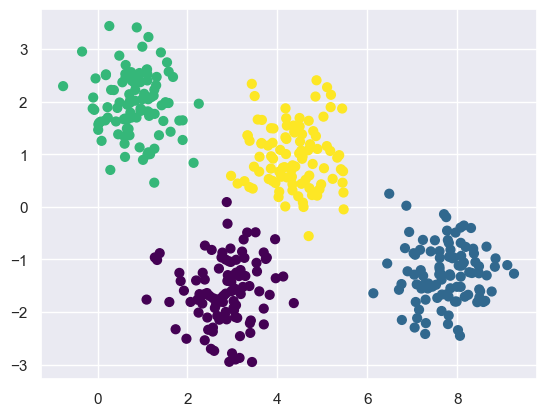

In [4]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans

kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

Desde un punto de vista intuitivo, podríamos esperar que la asignación de agrupamiento para algunos puntos sea más segura que para otros.

Por ejemplo, parece haber una superposición muy leve entre los dos agrupamientos intermedios, por lo que es posible que no tengamos total confianza en la asignación del agrupamiento. de puntos entre ellos.

Desafortunadamente, el modelo K-means no tiene una medida intrínseca de probabilidad o incertidumbre de las asignaciones de conglomerados.Para ello, debemos pensar en generalizar el modelo.

Una forma de pensar en el modelo de k-means es que coloca un círculo (o, en dimensiones más altas, una hiperesfera) en el centro de cada grupo, con un radio definido por el punto más distante del grupo. Este radio actúa como un límite estricto para la asignación de grupos dentro del conjunto de entrenamiento: cualquier punto fuera de este círculo no se considera miembro del grupo. Podemos visualizar este modelo de clúster con la siguiente función:

In [5]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

D:\SOFTWARE\Anaconda 3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


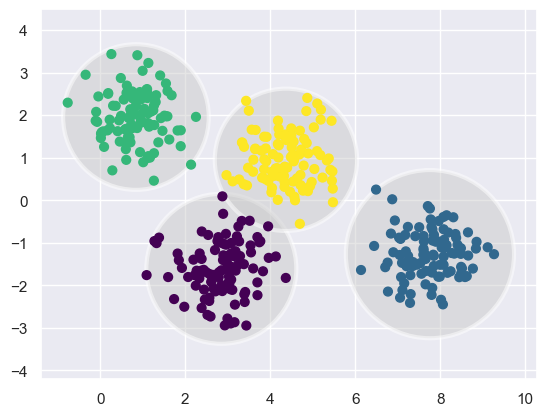

In [6]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

Una observación importante para k-means es que estos modelos de conglomerados **deben ser circulares**. k-means no tiene una forma integrada de contabilizar conglomerados oblongos o elípticos. Entonces, por ejemplo, si tomamos los mismos datos y los transformamos, las asignaciones de clústeres terminan siendo confusas:

D:\SOFTWARE\Anaconda 3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


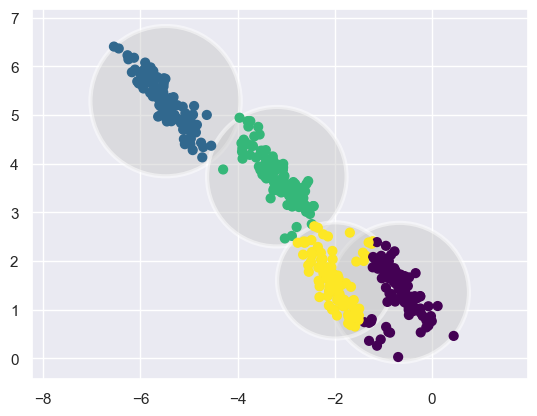

In [7]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

A simple vista, reconocemos que estos grupos transformados no son circulares y, por lo tanto, los grupos circulares no encajarían bien.

Sin embargo, k -means no es lo suficientemente flexible para dar cuenta de esto y trata de forzar el ajuste de los datos en cuatro grupos circulares. 

Esto da como resultado una mezcla de asignaciones de conglomerados donde los círculos resultantes se superponen: vea especialmente la parte inferior derecha de esta gráfica. Uno podría imaginar abordar esta situación particular preprocesando los datos con PCA, pero en la práctica no hay garantía de que una operación global de este tipo circularice los datos individuales.

### Entonces ...

Estas dos desventajas de k -means (su falta de flexibilidad en la forma del grupo y la falta de asignación de grupo probabilística) significan que para muchos conjuntos de datos (especialmente conjuntos de datos de baja dimensión) es posible que no funcione tan bien como cabría esperar.

Podría imaginar abordar estas debilidades generalizando el modelo de K-Means,podría medir la incertidumbre en la asignación de conglomerados comparando las distancias de cada punto con todos los centros de conglomerados, en lugar de centrarse solo en el más cercano; También puede imaginar permitir que los límites de los grupos sean elipses en lugar de círculos, para tener en cuenta los grupos no circulares. Resulta que estos son dos componentes esenciales de un tipo diferente de modelo de agrupamiento, los modelos de mezcla gaussiana.

### Gaussian Mixture Models

Un modelo de **GaussianMixture** (GMM) intenta encontrar una mezcla de distribuciones de probabilidad gaussianas multidimensionales que modelen mejor cualquier conjunto de datos de entrada. En el caso más simple, los GMM se pueden usar para encontrar grupos de la misma manera que k -means:

D:\SOFTWARE\Anaconda 3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


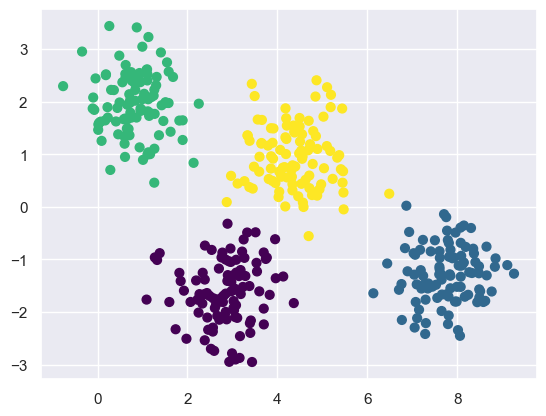

In [8]:
# from sklearn.mixture import GMM

# donde aparesca GMM => mixture.GaussianMixture

from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

Dentro del algoritmo de Mixture.GaussianMixture encontramos un modeo probabilistico por lo que tambien podemos asignar clusteres probabilisticos, en SCIKIT LEARN est se hace usando el metodo **predict_proba**, la cual devuelve una matriz de tamaño $[n_samples, n_clusters]$ que mide a probabilidad de que cualquier punto pertenezca al grado dado.

In [9]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.463 0.    0.537]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


Podemos visualizar esta incertidumbre, por ejemplo, haciendo que el tamaño de cada punto sea proporcional a la certeza de su predicción; Al observar la siguiente figura, podemos ver que son precisamente los puntos en los límites entre los grupos los que reflejan esta incertidumbre de asignación de grupos:

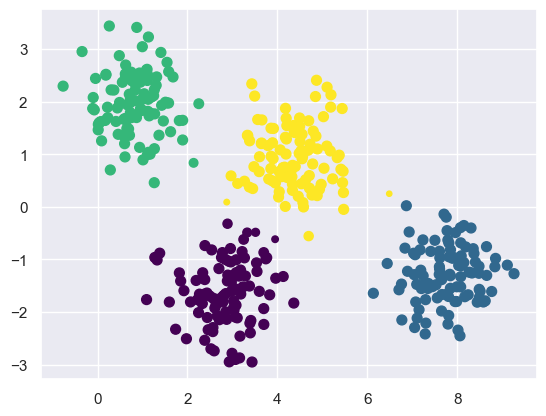

In [10]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size)

Bajo el capó, un modelo de GaussianMixture es muy similar a k-means, pues utiliza un enfoque de maximización de expectativas que cualitativamente hace lo siguiente:

1. Elije conjeturas iniciales para la ubicacion y la forma.
2. Un loop hata que haya convergencia, dado por los siguiente parametros:

    a. E-step : para cada punto, encuentre pesos que codifiquen la probabilidad de pertenencia en cada grupo.
    
    b. M-step : para cada grupo, actualice su ubicación, normalización y forma en función de todos los puntos de datos, haciendo uso de los pesos
    
El resultado de esto es que cada grupo no está asociado con una esfera de bordes duros, sino con un modelo gaussiano uniforme. Al igual que en el enfoque de maximización de la expectativa k -means, este algoritmo a veces puede perder la solución óptima global y, por lo tanto, en la práctica se utilizan múltiples inicializaciones aleatorias.

Vamos a crear una función que nos ayude a visualizar las ubicaciones y las formas de los grupos de GMM dibujando elipses según la salida de GMM:

In [11]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

Con esto en su lugar, podemos echar un vistazo a lo que nos da el GMM de cuatro componentes para nuestros datos iniciales

In [12]:
from sklearn import mixture

In [13]:
gmm = mixture.GaussianMixture(n_components=4, random_state=42)

D:\SOFTWARE\Anaconda 3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


AttributeError: 'GaussianMixture' object has no attribute 'covars_'

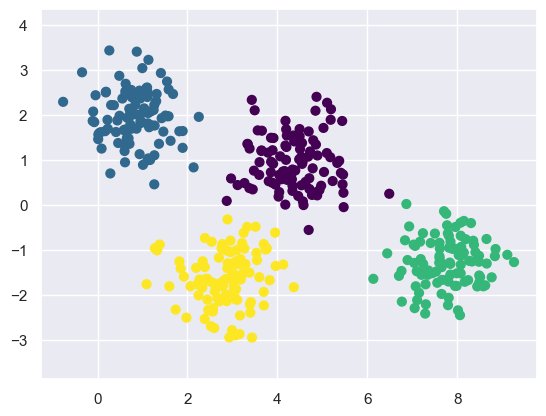

In [14]:
plot_gmm(gmm, X)

Por defecto de libreria no observamos bien en el anterior grafico los radios concentricos desde el nucleo de cada grupo, sin embargo el mismo debe verse de la siguiente manera:

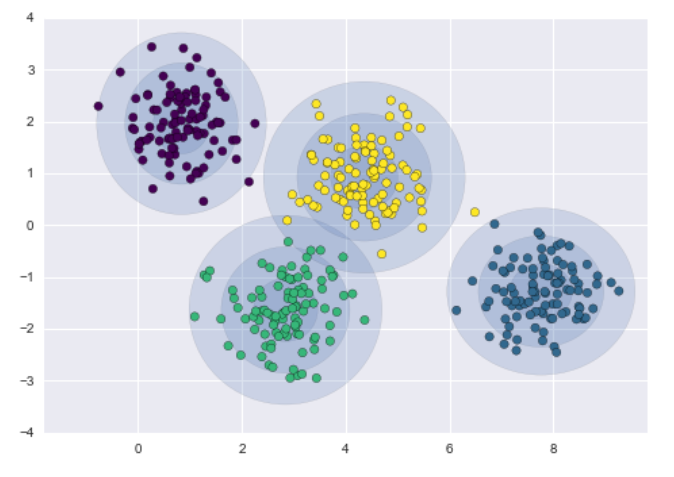

In [15]:
Image("gaussian.png")

De manera similar, podemos usar el enfoque GMM (mixture.GaussianMixture) para ajustar nuestro conjunto de datos ampliado.
Permitiendo una covarianza completa, el modelo se ajustará incluso a clústeres muy oblongos y estirados como se puede ver a continuacion:

D:\SOFTWARE\Anaconda 3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


AttributeError: 'GaussianMixture' object has no attribute 'covars_'

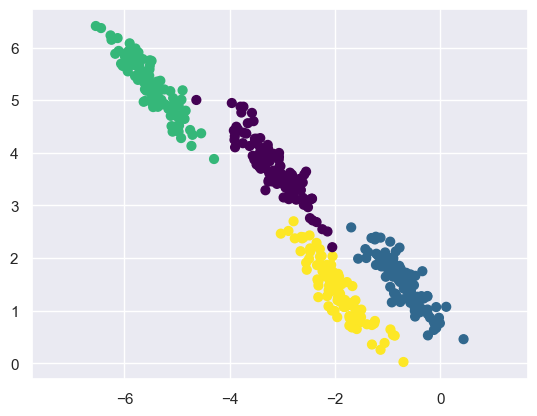

In [16]:
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

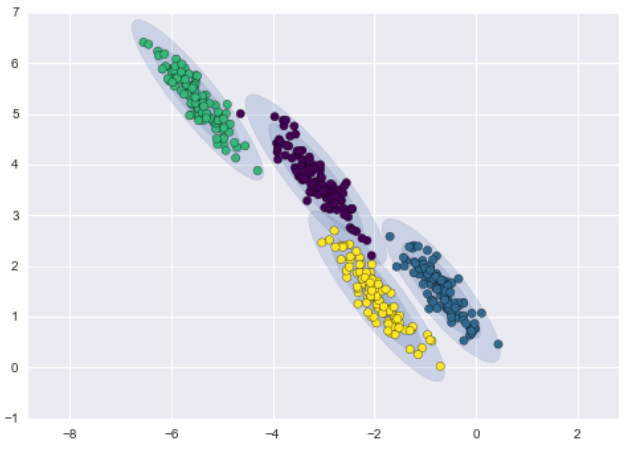

In [17]:
Image("gaussian2.png")

Esto deja en claro que GMM aborda los dos problemas prácticos principales con k -means encontrados antes.

### Como elejir el tipo de Covarianza

Si observa los detalles de los ajustes anteriores, verá que la **covariance_type** opción se estableció de manera diferente dentro de cada uno. Este hiperparámetro controla los grados de libertad en la forma de cada grupo; es esencial configurar esto cuidadosamente para cualquier problema dado. 

El valor predeterminado es **covariance_type="diag"**, lo que significa que el tamaño del clúster a lo largo de cada dimensión se puede establecer de forma independiente, con la elipse resultante restringida para alinearse con los ejes.

Un modelo un poco más simple y rápido es **covariance_type="spherical"**, que restringe la forma del grupo de modo que todas las dimensiones sean iguales. El agrupamiento resultante tendrá características similares a las de k -means, aunque no es del todo equivalente. 

Un modelo más complicado y computacionalmente costoso (especialmente a medida que crece el número de dimensiones) es usar **covariance_type="full"**, que permite modelar cada clúster como una elipse con orientación arbitraria.

Podemos observar el uso de las anteriores covarianzas en lo siguiente:



In [18]:
#from sklearn.mixture import GMM
from sklearn import mixture
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05)

rng = np.random.RandomState(5)
X = np.dot(rng.randn(500, 2), rng.randn(2, 2))

for i, cov_type in enumerate(['diag', 'spherical', 'full']):
    model = mixture.GaussianMixture(1, covariance_type=cov_type).fit(X)
    ax[i].axis('equal')
    ax[i].scatter(X[:, 0], X[:, 1], alpha=0.5)
    ax[i].set_xlim(-3, 3)
    ax[i].set_title('covariance_type="{0}"'.format(cov_type),size=14, family='monospace')
    draw_ellipse(model.means_[0], model.covars_[0], ax[i], alpha=0.2)
    ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    ax[i].yaxis.set_major_formatter(plt.NullFormatter())

fig.savefig('05.12-covariance-type.png')

## NOTA: Este codigo para su funcionamiento debe actualizarse para poder arrojar un grafico como el que s emuestra a continuacion

D:\SOFTWARE\Anaconda 3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


AttributeError: 'GaussianMixture' object has no attribute 'covars_'

RuntimeError: adjustable='datalim' is not allowed when both axes are shared

<Figure size 1400x400 with 3 Axes>

**NOTA: Este codigo para su funcionamiento debe actualizarse para poder arrojar un grafico como el que s emuestra a continuacion**

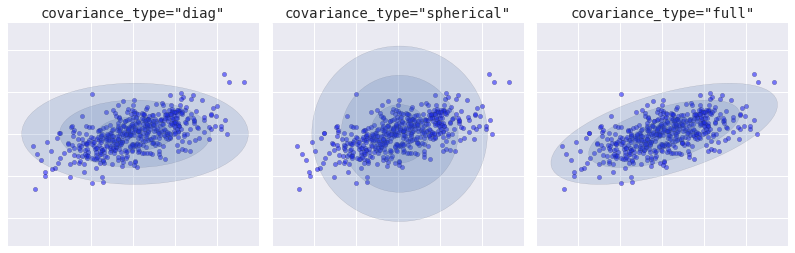

In [19]:
Image("gaussian3.png")

### GMM: Estimacion de Densidad

Aunque GMM a menudo se clasifica como un algoritmo de agrupamiento, fundamentalmente es un algoritmo para la estimación de densidad .

Es decir, el resultado de un ajuste de GMM a algunos datos técnicamente no es un modelo de agrupamiento, sino un modelo probabilístico generativo que describe la distribución de los datos.

Como ejemplo, considere algunos datos generados a partir de la función de Scikit-Learn **make_moons**. el mismo lo vimos en la **GUIA de K-Means**

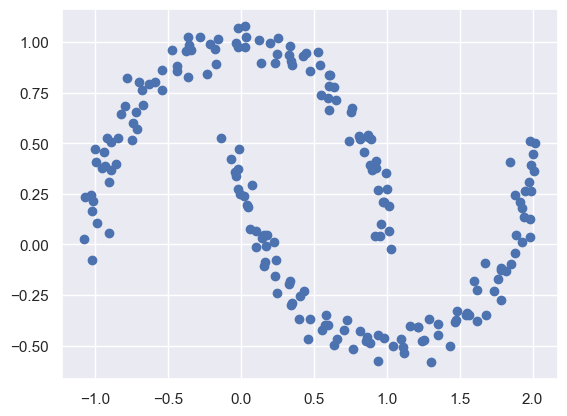

In [20]:
from sklearn.datasets import make_moons

Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

Si tratamos de ajustar esto con un GMM de dos componentes visto como un modelo de agrupamiento, los resultados no son particularmente útiles:

D:\SOFTWARE\Anaconda 3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


AttributeError: 'GaussianMixture' object has no attribute 'covars_'

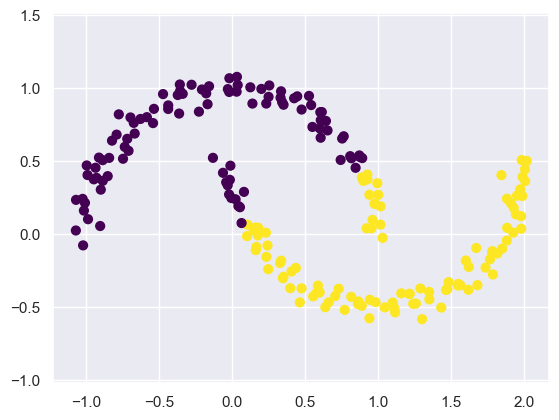

In [24]:
gmm2 = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

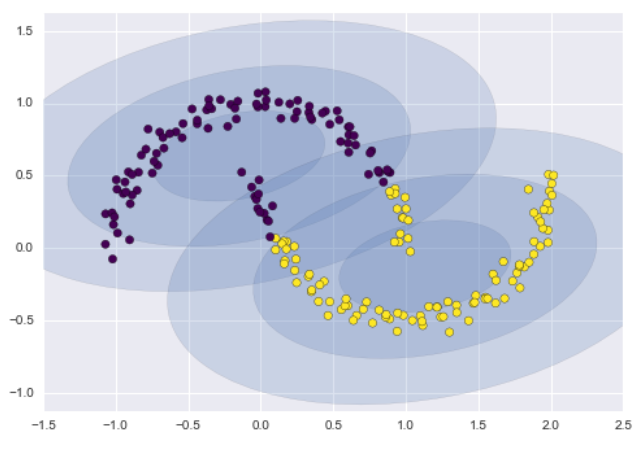

In [23]:
Image("gaussian4.png")

Pero si, en cambio, usamos muchos más componentes e ignoramos las etiquetas de los grupos, encontramos un ajuste mucho más cercano a los datos de entrada:

D:\SOFTWARE\Anaconda 3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


AttributeError: 'GaussianMixture' object has no attribute 'covars_'

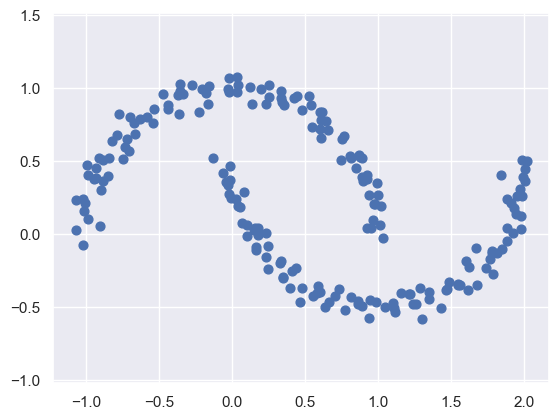

In [25]:
# mixture.GaussianMixture
gmm16 = mixture.GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

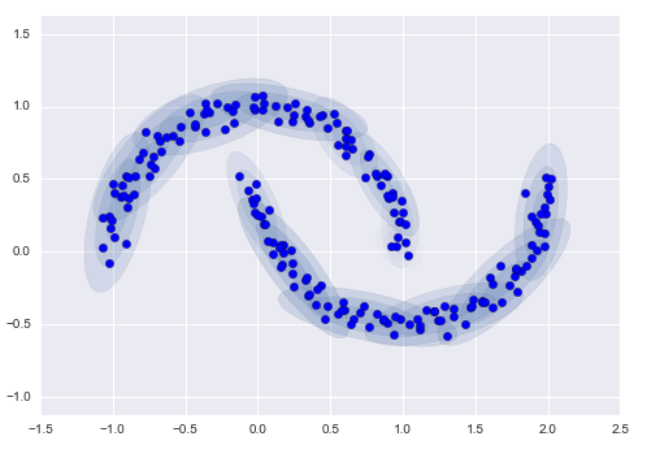

In [26]:
Image("gaussian5.png")

Aquí, la combinación de 16 gaussianas no sirve para encontrar grupos de datos separados, sino para modelar la distribución general de los datos de entrada. 

 Este es un modelo generativo de la distribución, lo que significa que el GMM nos da la receta para generar nuevos datos aleatorios distribuidos de manera similar a nuestra entrada.
 
 Por ejemplo, aquí hay 400 puntos nuevos extraídos de este GMM de 16 componentes que se ajusta a nuestros datos originales:

In [27]:
Xnew = gmm16.sample(400, random_state=42)
plt.scatter(Xnew[:, 0], Xnew[:, 1])

TypeError: sample() got an unexpected keyword argument 'random_state'

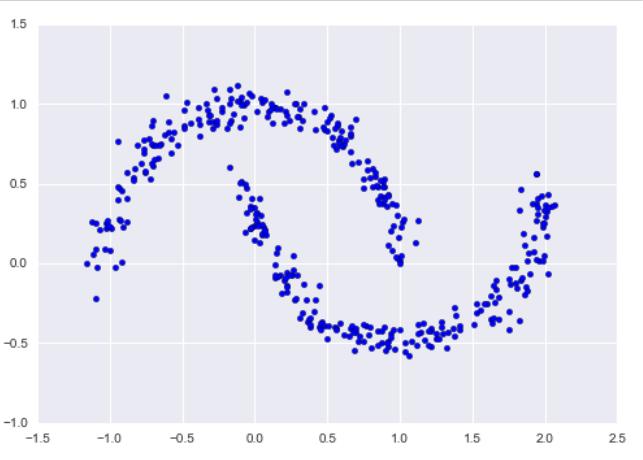

In [28]:
Image("gaussian6.png")

GMM es conveniente como un medio flexible para modelar una distribución de datos multidimensional arbitraria.

### ¿Cuantos componentes podemos utilizar?

El hecho de que GMM sea un modelo generativo nos brinda un medio natural para determinar la cantidad óptima de componentes para un conjunto de datos determinado. 

Un modelo generativo es inherentemente una distribución de probabilidad para el conjunto de datos, por lo que simplemente podemos evaluar la probabilidad de los datos bajo el modelo, utilizando la validación cruzada para evitar el ajuste excesivo. Otro medio de corregir el sobreajuste es ajustar las probabilidades del modelo utilizando algún criterio analítico, como el criterio de información de Akaike (AIC) o el criterio de información bayesiano (BIC) .

El estimador de Scikit-Learn en GMMrealidad incluye métodos integrados que calculan ambos, por lo que es muy fácil operar con este enfoque.

Veamos el AIC y el BIC como una función del número de componentes GMM para nuestro conjunto de datos lunares:

D:\SOFTWARE\Anaconda 3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\SOFTWARE\Anaconda 3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\SOFTWARE\Anaconda 3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\SOFTWARE\Anaconda 3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with M

Text(0.5, 0, 'n_components')

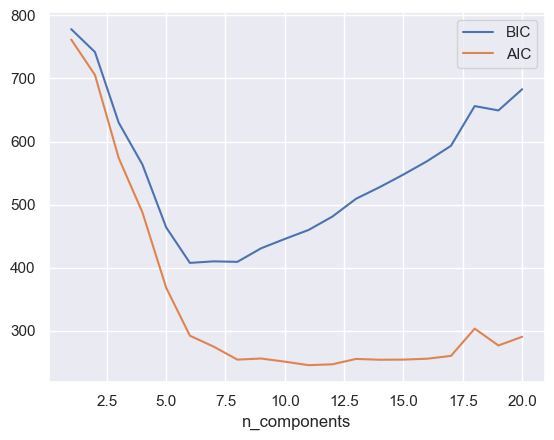

In [30]:
n_components = np.arange(1, 21)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

El número óptimo de clusters es el valor que minimiza el AIC o el BIC, según la aproximación que queramos utilizar.

El AIC nos dice que nuestra elección de los 16 componentes anteriores probablemente fue demasiado, entre 8 y 12 componentes habría sido una mejor opción.

Como es típico con este tipo de problema, el BIC recomienda un modelo más simple.

Observe el punto importante; esta elección de número de componentes mide qué tan bien funciona GMM como estimador de densidad , no qué tan bien funciona como algoritmo de agrupamiento.

Lo animo a pensar en GMM principalmente como un estimador de densidad y usarlo para agrupar solo cuando se justifique dentro de conjuntos de datos simples.